Implementing Graph Convolutional Network (GCN) in DGL
=====================================================

Graph convolutional network (GCN) is a popular model proposed by [Kipf & Welling](https://arxiv.org/abs/1609.02907) to encode graph structure by message passing. The high-level idea is similar to our toy task: node features are updated by aggregating the messages from the neighbors. Here is its message passing equation:

$$
h_{v_i}^{(l+1)} = \sigma \left(\sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_{v_j}^{(l)}W^{(l)} \right)
$$

, where $v_i$ is any node in the graph; $h_{v_i}$ is the feature of node $v_i$; $\mathcal{N}(i)$ denotes the neighborhood of $v_i$; $c_{ij}$ is the normalization constant related to node degrees; $W$ is the parameter and $\sigma$ is a non-linear activation function.

In [5]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The steps to implement GCN in DGL is also similar to the toy task (2_MessagePassing.ipynb):
* Define the message function.
* Define the reduce function.
* Define how they are triggered using `send` and `recv`.

We first pretend that we already have implemented the message function `gcn_message` and reduce function `gcn_reduce`, and look at how we can define GCN layer and trigger computation with `send` and `recv`:

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Define the GCN module
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # trigger message passing, gcn_message and gcn_reduce will be defined later
        g.send(g.edges(), gcn_message)
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        return h

Now let's fill in the missing message and reduce function. For simplicity, for now, we ignore the normalization constant $c_{ij}$.

From the equation of GCN above:
- each node sends out the embedding after linear transformation to their neighbors, so the message from node $u$ to node $v$ can be computed as
$$m_{uv} = h_u$$
- each node aggregates received messages by summation, so the aggregated messages on node $v$ can be computed as
$$a_v = \sum\limits_{u\in \mathcal{N}(v)}m_{uv}$$, where $\mathcal{N}(v)$ is the neighbor set of node $v$.

### Exercise:
Follow the two equations above and finish the message & reduce function for Graph Convolutional Network based on the equation above.

NOTE: for now, we ignore the normalization factor $c_{ij}$

NOTE: message function and reduce function should return a feature dictionary instead of one single tensor.

In [7]:
# >>> YOUR CODE STARTS
def gcn_message(edges):
    # Send features of source nodes as message.
    # Hint 1: you can access the feature dictionary of source node, destination node and edges with
    #         edges.src, edges.dst, edges.data
    # Hint 2: name of the node feature is decided when you set the feature in GCN forward function
    return {'msg': edges.src['h']}

def gcn_reduce(nodes):
    # Aggregate messages from neighbors by summation.
    # Hint 1: messages are delivered into mailbox and you can access it using nodes.mailbox
    # Hint 2: mailbox is the same as the feature dictionary you return in gcn_message
    return {'h': nodes.mailbox['msg'].sum(dim=1)}
# >>> YOUR CODE ENDS

In this tutorial, we will still use karate club as example. Let's use the helpful utility function to load the graph and make it bidirectional with self loop:

In [8]:
import dgl, torch
import networkx as nx
from tutorial_utils import create_karate_graph, convert_to_bidirectional
G = create_karate_graph()
GG = convert_to_bidirectional(G)

To test this model, let's try to predict which club member will join whose group (instructor or club president) after the split. We adopt the semi-supervised setting developed by Kipf:

In [9]:
# Define a 2-layer GCN model
class Net(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(Net, self).__init__()
        self.gcn1 = GCN(in_feats, hidden_size)
        self.gcn2 = GCN(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

inputs = torch.eye(34)  # featureless inputs
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different
net = Net(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

all_logits = []
for epoch in range(30):
    logits = net(GG, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for node 0 and node 33
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.5469
Epoch 1 | Loss: 0.3771
Epoch 2 | Loss: 0.5854
Epoch 3 | Loss: 0.4600
Epoch 4 | Loss: 0.1877
Epoch 5 | Loss: 0.0652
Epoch 6 | Loss: 0.0406
Epoch 7 | Loss: 0.0437
Epoch 8 | Loss: 0.0508
Epoch 9 | Loss: 0.0531
Epoch 10 | Loss: 0.0490
Epoch 11 | Loss: 0.0404
Epoch 12 | Loss: 0.0312
Epoch 13 | Loss: 0.0228
Epoch 14 | Loss: 0.0165
Epoch 15 | Loss: 0.0119
Epoch 16 | Loss: 0.0087
Epoch 17 | Loss: 0.0064
Epoch 18 | Loss: 0.0048
Epoch 19 | Loss: 0.0036
Epoch 20 | Loss: 0.0028
Epoch 21 | Loss: 0.0023
Epoch 22 | Loss: 0.0018
Epoch 23 | Loss: 0.0015
Epoch 24 | Loss: 0.0013
Epoch 25 | Loss: 0.0011
Epoch 26 | Loss: 0.0010
Epoch 27 | Loss: 0.0008
Epoch 28 | Loss: 0.0008
Epoch 29 | Loss: 0.0007


/Users/aviv/anaconda3/envs/cs236605-tutorials/lib/python3.7/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


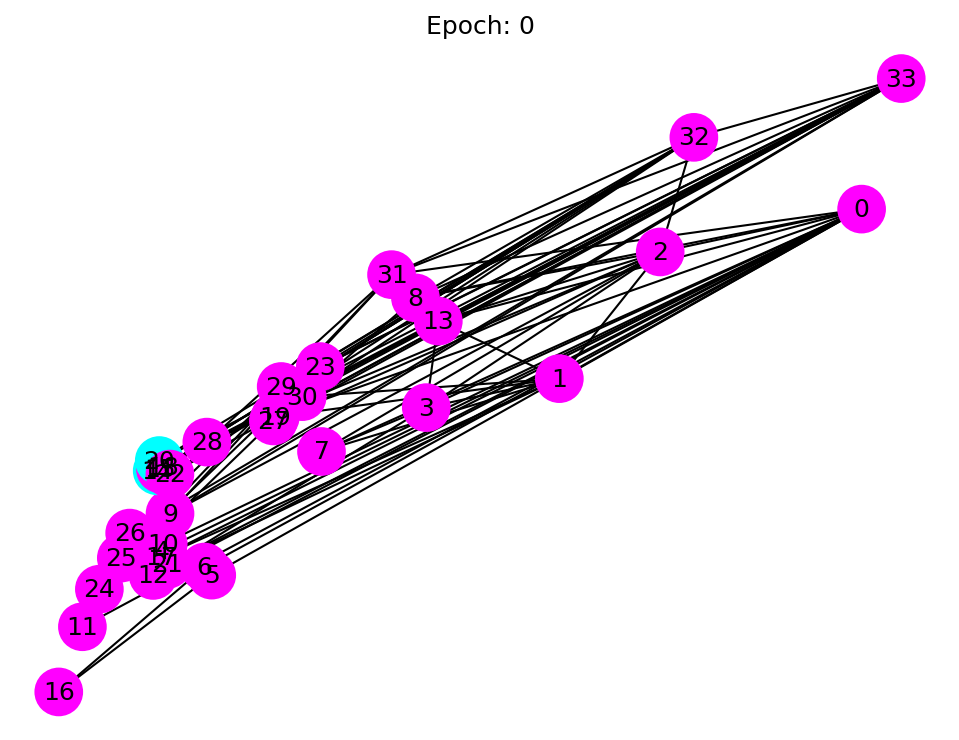

In [10]:
# Visualize the node classification using the logits output.
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = G.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = np.argmax(pos[v])
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=500)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

### Exercise

There is still one missing piece. In our GCN model, 
$$
h_{v_i}^{(l+1)} = \sigma \left(\sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_{v_j}^{(l)}W^{(l)} \right)
$$
And we haven't implemented the normalizer $c_{ij}$. Kipf, in GCN paper, pointed out that the normalizer should be computed as follows:

$$
c_{ij} = \sqrt{d_id_j}
$$

, where $d_i, d_j$ are the degrees of node $v_i$ and $v_j$ respectively. Your task is to modify the program to implement it.

**Hint #1**: Use `GG.in_degrees(GG.nodes())` to get a 1-D tensor containing the degrees of all the nodes.

**Hint #2**: Since $c_{ij}$ has a subscription $ij$, it is tied to the edges, and our message function is (not coincidently) an **edge UDF**.

Have fun :)

In [11]:
# >>> YOUR CODE STARTS
# You need to make two changes:

# 1. Get the degrees of nodes and make them a node feature. You can do this in forward function of GCN, 
#    or during pre-processing
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # set node degrees
        g.ndata['deg'] = g.in_degrees(g.nodes())
        # trigger message passing, gcn_message and gcn_reduce will be defined later
        g.send(g.edges(), gcn_message)
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        return h
    
# 2. Update the message function and use node degree to compute normalization factor
def gcn_message(edges):
    return {'msg': torch.sqrt(edges.src['deg'] * edges.dst['deg']) * edges.src['h']}

# <<< YOUR CODE ENDS